In [204]:
import sklearn
import lightgbm as lgb
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.datasets import load_wine
import mlflow as mf
from mlflow import log_metric, log_param, log_artifact
import mlflow.lightgbm
import matplotlib.pyplot as plt
import seaborn as sns
import logging
logging.basicConfig(level = logging.INFO)
logger = logging.getLogger()

pd.options.display.max_rows = 50
pd.options.display.max_columns = 50
%matplotlib inline

dataset = load_wine()

## ML Evaluation plot

In [219]:
def plotImp(model, X , title,num = 16):
    feature_imp = pd.DataFrame({'Value':model.feature_importance(),'Feature':X.columns})
    plt.figure(figsize=(12,7))
    sns.set(font_scale = 1.1)
    sns.barplot(color="lightblue",x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title(title)
    plt.tight_layout()
    plt.savefig('Importances')
    
    
    #plt.savefig(fig2_fn)
   
    fig1_fn = 'figure_importants.png'
    plt.savefig(fig1_fn)
    mlflow.log_artifact(fig1_fn) # logging to mlflow   
    plt.show()
  
    
def confusion_matrix_test(y_test, y_predict):
    plt.figure()
    cm = confusion_matrix(y_test, y_predict)
    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]*100
    sns.set(font_scale=1.2)
    labels = ['0', '1','2']
    plt.figure(figsize=(8,7))
    #sns.heatmap(cm, xticklabels = labels, yticklabels = labels, annot = True, fmt='d', cmap="Blues", vmin = 0.2);
    sns.heatmap(cmn, xticklabels = labels, yticklabels = labels, annot = True, fmt='.2f', cmap="Blues")
    plt.title('Confusion Matrix')
    plt.ylabel('True Class')
    plt.xlabel('Predicted Class')

    fig1_fn = 'cm.png'
    plt.savefig(fig1_fn)
    mlflow.log_artifact(fig1_fn) # logging to mlflow   
    plt.show()
    
    
    plt.show()

## Data preprocessing and EDA

In [206]:
data = pd.DataFrame(data= np.c_[dataset['data'], dataset['target']],
                     columns= dataset['feature_names'] + ['target'])
#data.to_csv('data.csv')

In [207]:
data.head(2)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0.0


In [208]:
data.describe()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258,0.938202
std,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474,0.775035
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000,0.000000
25%,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000,0.000000
50%,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000,1.000000
75%,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000,2.000000
max,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000,2.000000


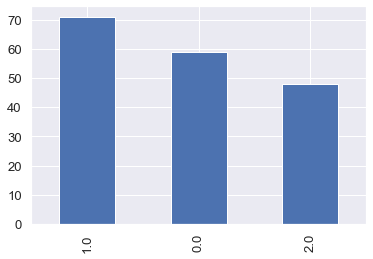

In [209]:
data.target.value_counts().plot.bar()

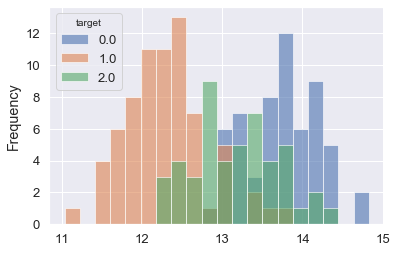

In [210]:
data.pivot(columns='target').alcohol.plot(alpha=0.6,kind = 'hist',bins=20)


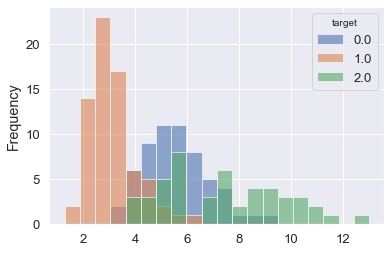

In [211]:
data.pivot(columns='target').color_intensity.plot(alpha=0.6,kind = 'hist', bins=20)

In [212]:
X = data.drop(columns=['target'])
y = data['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 100)
logger.info(f'Split into train set shape {X_train.shape} and test set shape {X_test.shape}')


INFO:root:Split into train set shape (133, 13) and test set shape (45, 13)


## Model Training with MLFlow tracking 

In [213]:
train_set = lgb.Dataset(X_train, label=y_train)
test_set  = lgb.Dataset(X_test, label = y_test)

[1]	test's multi_logloss: 1.14748
[2]	test's multi_logloss: 1.13691
[3]	test's multi_logloss: 1.12659
[4]	test's multi_logloss: 1.1164
[5]	test's multi_logloss: 1.10645
[6]	test's multi_logloss: 1.09668
[7]	test's multi_logloss: 1.08709
[8]	test's multi_logloss: 1.07762
[9]	test's multi_logloss: 1.06836
[10]	test's multi_logloss: 1.05927
[11]	test's multi_logloss: 1.05016
[12]	test's multi_logloss: 1.04137
[13]	test's multi_logloss: 1.03277
[14]	test's multi_logloss: 1.02395
[15]	test's multi_logloss: 1.01563
[16]	test's multi_logloss: 1.00739
[17]	test's multi_logloss: 0.99916
[18]	test's multi_logloss: 0.990706
[19]	test's multi_logloss: 0.982757
[20]	test's multi_logloss: 0.974962
[21]	test's multi_logloss: 0.966896
[22]	test's multi_logloss: 0.95919
[23]	test's multi_logloss: 0.951504
[24]	test's multi_logloss: 0.943844
[25]	test's multi_logloss: 0.936485
[26]	test's multi_logloss: 0.929161
[27]	test's multi_logloss: 0.921785
[28]	test's multi_logloss: 0.914768
[29]	test's multi_lo

INFO:root:f1_score macro: 0.9035015164047421
INFO:root:precision_score macro: 0.9242424242424242
INFO:root:recall_score macro: 0.9074074074074074
INFO:root:f1_score weighted: 0.8870508225346936
INFO:root:precision_score weighted: 0.9141414141414143
INFO:root:recall_score weighted: 0.8888888888888888


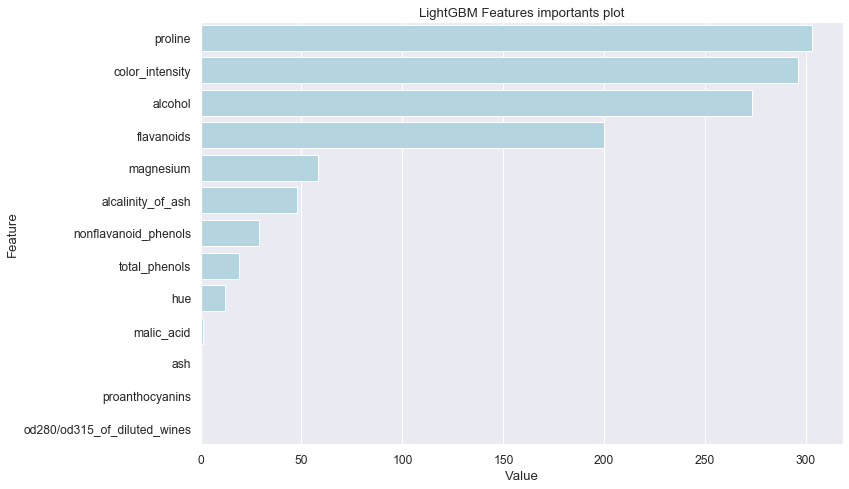

<Figure size 864x504 with 0 Axes>

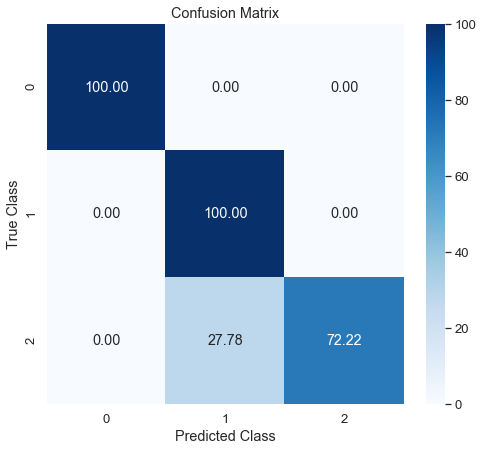

In [222]:
    mf.set_experiment('MLflow expriement example')

    with mlflow.start_run():

        params={}
        params['learning_rate']=0.01
        params['boosting_type']='gbdt' #GradientBoostingDecisionTree
        params['objective']='multiclass' #Multi-class target feature
        params['metric']='multi_logloss' #metric for multi-class
        params['max_depth']=15
        params['num_class']=3
        
             
        clf = lgb.train(params, train_set, num_boost_round=100, valid_sets=[test_set], valid_names=['test'])
        preds = clf.predict(X_test)
        predictions = []

        for x in preds:
            predictions.append(np.argmax(x))
        from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

        print(classification_report(y_test, predictions))
        
        # log artifact: classification_report
        plt.rc('figure', figsize=(12, 7))
        plt.text(0.01, 0.05, str(classification_report(y_test, predictions)), {'fontsize': 10}, fontproperties = 'monospace') 
        plt.axis('off')
        plt.tight_layout()
        summary_fn = 'clf_summary.png'
        plt.savefig(summary_fn)
        mlflow.log_artifact(summary_fn) # logging to mlflow
        plt.close()
        
        
        
        f1_macro=f1_score(y_test, predictions, average="macro")
        precision_macro=precision_score(y_test, predictions, average="macro")
        recall_macro=recall_score(y_test, predictions, average="macro") 
        f1_weighted=f1_score(y_test, predictions, average="weighted")
        precision_weighted=precision_score(y_test, predictions, average="weighted")
        recall_weighted=recall_score(y_test, predictions, average="weighted")
        
        logger.info(f'f1_score macro: {f1_macro}')
        logger.info(f'precision_score macro: {precision_macro}')
        logger.info(f'recall_score macro: {recall_macro}')
        logger.info(f'f1_score weighted: {f1_weighted}')
        logger.info(f'precision_score weighted: {precision_weighted}')
        logger.info(f'recall_score weighted: {recall_weighted}')
        
        #log the ML model params and stats with MLflow 
        mf.log_param("learning_rate", params['learning_rate'])
        mf.log_param("max_depth", params['max_depth'])
        mf.log_param("boosting_type",  params['boosting_type'])


        mf.log_metric('F1_macro', f1_macro)
        mf.log_metric('Precision_macro', precision_macro)
        mf.log_metric('Recall_macro', recall_macro)
        mf.log_metric('F1_score weighted', f1_weighted)
        mf.log_metric('Precision_score weighted', precision_weighted)
        mf.log_metric('Recall_score weighted', recall_weighted)
        
        mf.log_artifact('data.csv')
        mf.lightgbm.log_model(model, 'clf')

        plotImp(clf,X_train,'LightGBM Features importants plot')   
        confusion_matrix_test(y_test, predictions)
        mf.end_run()

In [217]:
mf.end_run()